**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Importing Data

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/Users/jh/Melonoma CNN Model/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/Users/jh/Melonoma CNN Model/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Below is the code to visualize one instance of all the nine classes present in the dataset

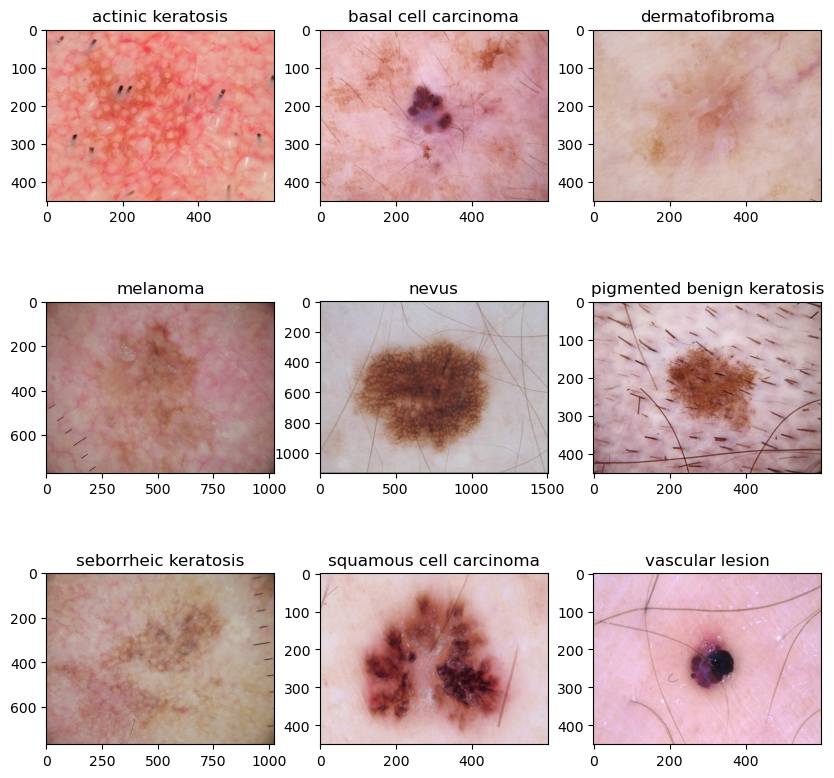

In [8]:
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Below is the first base model we have created:

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Rescaling

num_classes = 9
img_height = 180
img_width = 180

model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3))
])

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

/Users/jh/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        34,857 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,817 (546.16 KB)

 Trainable params: 139,817 (546.16 KB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
from tensorflow.keras.optimizers import RMSprop

### As it is a multi class classification, we are using SparseCategoricalCrossEntropy as the loss function, and we are using adam optimizer as a hit & trial, further we can perform hyper parameter optimization and change the optimizer accordingly

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        34,857 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,817 (546.16 KB)

 Trainable params: 139,817 (546.16 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/Users/jh/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.1787 - loss: 2.0792 - val_accuracy: 0.2058 - val_loss: 2.0456
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.1766 - loss: 2.0654 - val_accuracy: 0.2036 - val_loss: 1.9573
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.2470 - loss: 1.9473 - val_accuracy: 0.3020 - val_loss: 1.8515
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.2862 - loss: 1.8610 - val_accuracy: 0.3110 - val_loss: 1.7803
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.3517 - loss: 1.7663 - val_accuracy: 0.4183 - val_loss: 1.6336
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.3965 - loss: 1.6009 - val_accuracy: 0.3490 - val_loss: 1.6999
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4453 - loss: 1.5277 - val_accuracy: 0.4228 - val_loss: 1.5997
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4472 - loss: 1.5050 - val_accuracy: 0.3893 - val_loss: 1.6224
Epo

### Visualizing training results

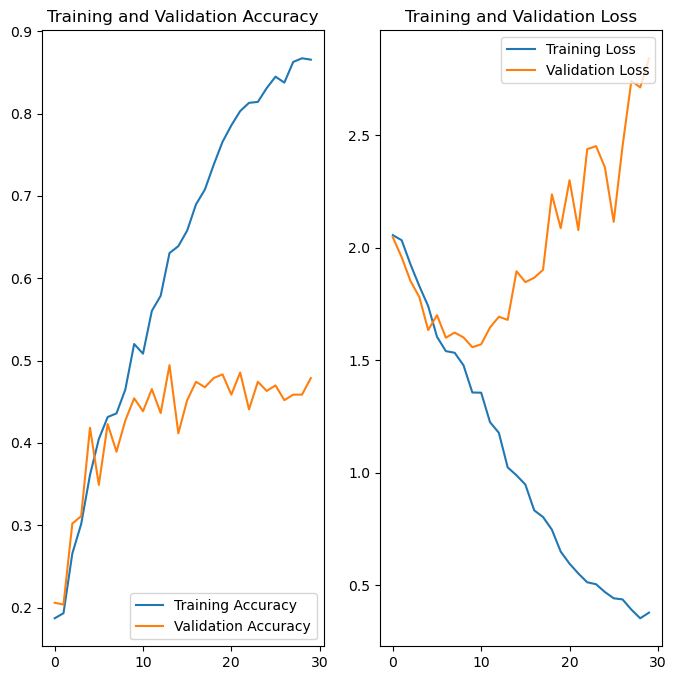

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings on the first base model


*   Initial findings: The model is overfitting because overfitting is calculated w.r.t loss, and we can also see difference in loss functions in training & test around the 19-20th epoch 
*   The accuracy is just around 50-60% because there are enough features to remember the pattern, and the neural network is very young (just 20 epochs), so the learning has just started
*   But again, it's too early to comment on the overfitting & underfitting debate



In [21]:

from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

img_height = 180
img_width = 180

data_aug = Sequential([
    RandomFlip(mode="horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.2, fill_mode='reflect'),
    RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

# Ensure to import these properly
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Print a summary of the data augmentation model
data_aug.summary()


/Users/jh/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 180, 180, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

2024-08-06 17:35:31.520899: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


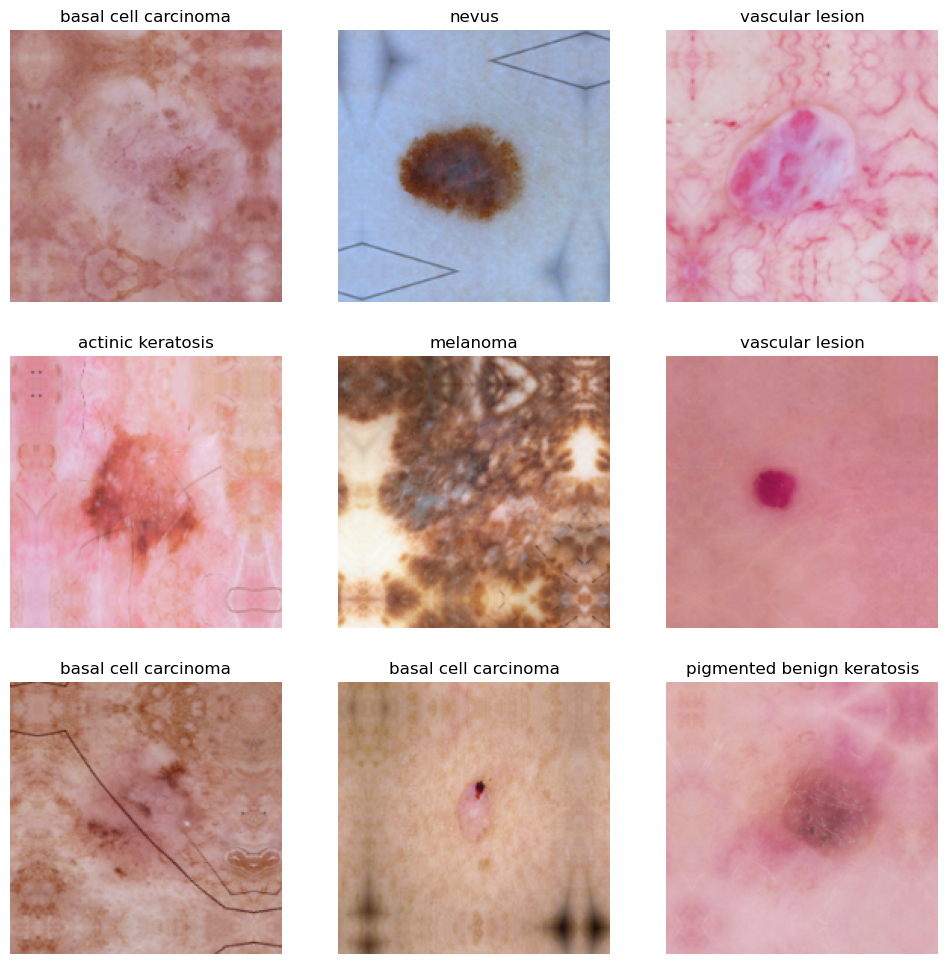

In [22]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Model Creation, compilation and training the model


In [25]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Rescaling, RandomFlip, RandomRotation, RandomZoom

num_classes = 9
img_height = 180
img_width = 180

# Data augmentation
data_aug = Sequential([
    RandomFlip(mode="horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.2, fill_mode='reflect'),
    RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

model = Sequential([
    data_aug,
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'),
    Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

model.summary()


/Users/jh/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [27]:
## Your code goes here, note: train your model for 100 epochs
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/Users/jh/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 4007s 73s/step - accuracy: 0.1869 - loss: 2.0824 - val_accuracy: 0.2170 - val_loss: 2.0267
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 548s 10s/step - accuracy: 0.1959 - loss: 2.0119 - val_accuracy: 0.2349 - val_loss: 2.0288
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2300 - loss: 2.0298 - val_accuracy: 0.3043 - val_loss: 1.9106
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2910 - loss: 1.8528 - val_accuracy: 0.3154 - val_loss: 1.8307
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.3581 - loss: 1.7532 - val_accuracy: 0.3423 - val_loss: 1.7458
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3756 - loss: 1.6945 - val_accuracy: 0.3557 - val_loss: 1.7165
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3807 - loss: 1.6319 - val_accuracy: 0.4251 - val_loss: 1.6172
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.3953 - loss: 1.6173 - val_accuracy: 0.4430 - val_loss: 1.603

### Visualizing the results

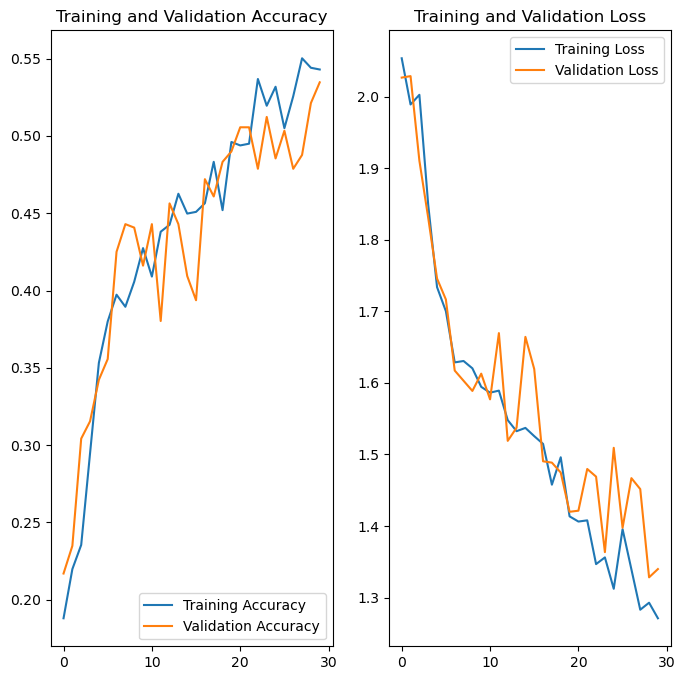

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:


*   We don't see much improvements with respect to accuracy from the base model, but we can definitely see the overfitting issue fading away due to data augmentation
*   But again, judging based on just 20 epochs won't give us proper conclusions



## Finding the distribution of classes in the training dataset.


In [29]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,actinic keratosis
1,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,actinic keratosis
2,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,actinic keratosis
3,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,actinic keratosis
4,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,actinic keratosis
...,...,...
2234,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,vascular lesion
2235,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,vascular lesion
2236,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,vascular lesion
2237,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,vascular lesion


In [30]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,actinic keratosis
1,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,actinic keratosis
2,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,actinic keratosis
3,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,actinic keratosis
4,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,actinic keratosis
...,...,...
2234,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,vascular lesion
2235,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,vascular lesion
2236,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,vascular lesion
2237,/Users/jh/Melonoma CNN Model/Skin cancer ISIC ...,vascular lesion


<BarContainer object of 9 artists>

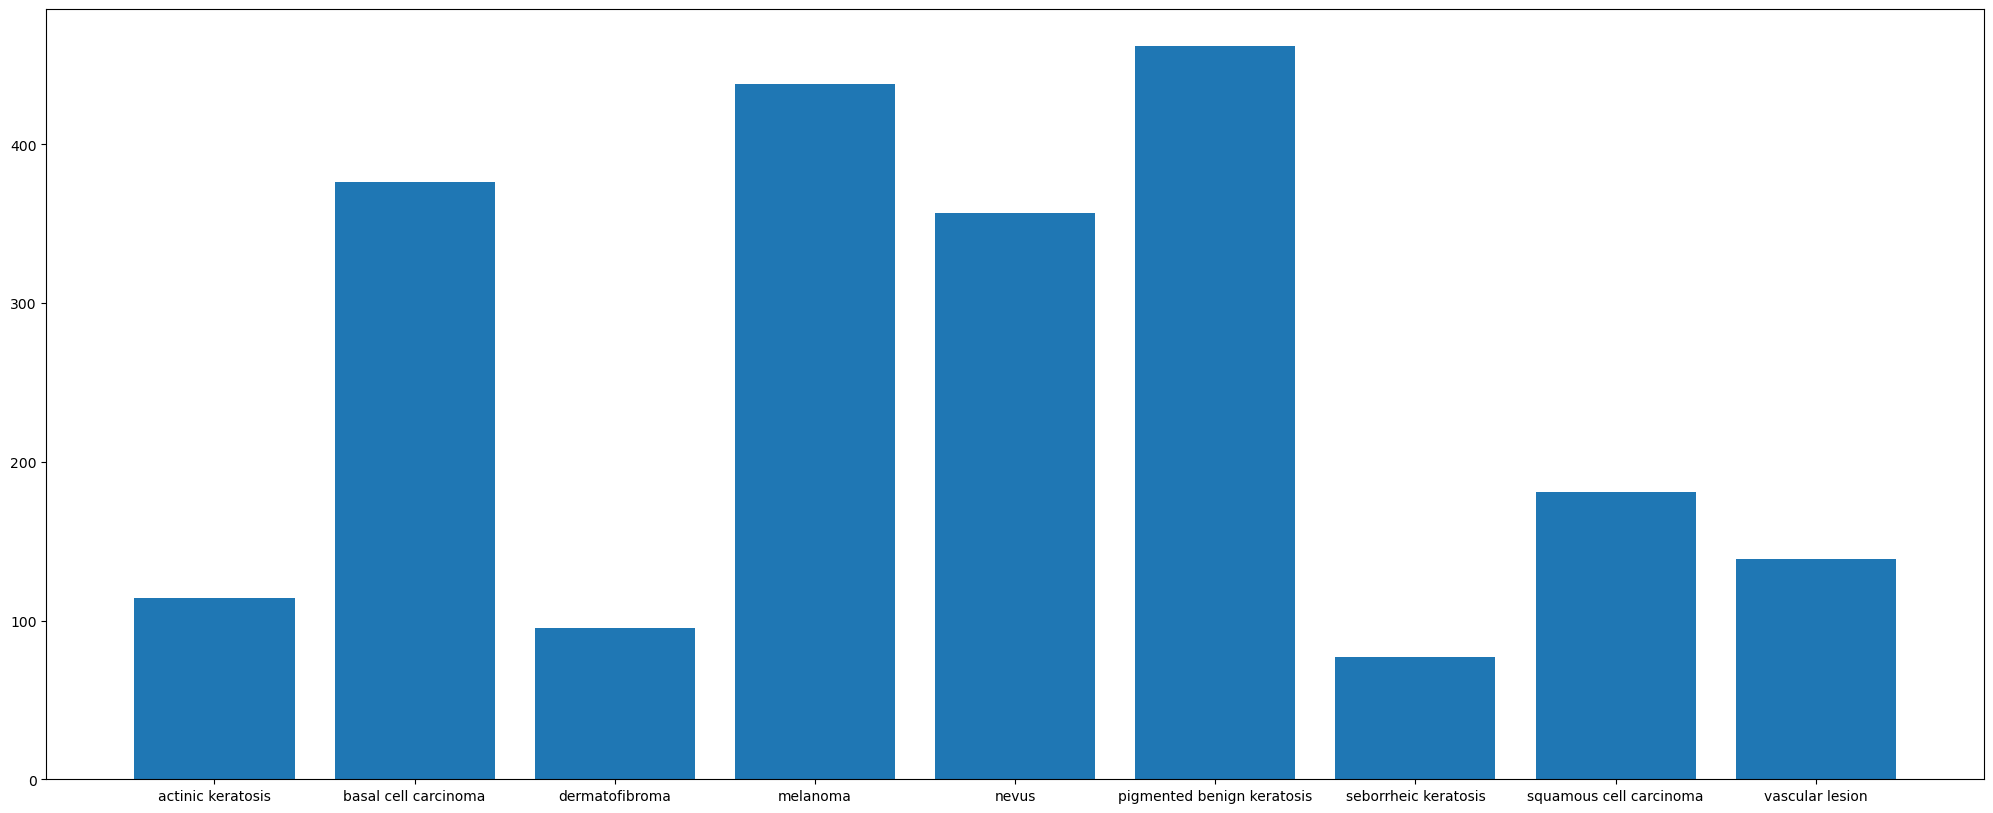

In [31]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

### Findings

#### - Seborrheic keratosis is having the lowest distribution
#### - Pigmented Benign keratosis is having the highest distribution of data


#### Visualize the model results

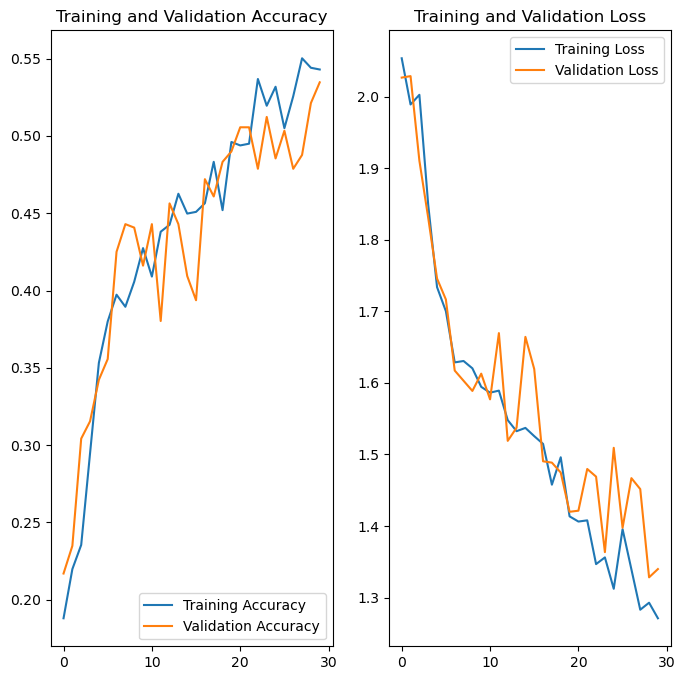

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()